In [1]:
import numpy as np
import healpy as hp
import pandas as pd

import datetime

import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import coordinates
from astropy import units as u
from astropy.io import fits

from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.affinity import translate
from descartes.patch import PolygonPatch

from skipper import observe, shape, hsc, tiling

In [2]:
def read_tile_file(filename):
    hdul = fits.open(filename)
    data = hdul[1].data
    tileID = data['TILEID']
    pass_num = data['PASS']
    ra = data['RA']
    dec = data['DEC']
    
    return tileID, pass_num, ra, dec

## import tiling file

In [3]:
tileID_shift, pass_num_shift, ra_shift, dec_shift = read_tile_file('../data/shifted-tiles-decals-merian.fits.gz')
circle_radius = (3.18/np.pi)**0.5

## read pointings coordinates


In [4]:
ra1_shift = np.array([ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 1])
dec1_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 1]
ra2_shift = np.array([ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 2])
dec2_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 2]
ra3_shift = np.array([ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 3])
dec3_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 3]
ra4_shift = np.array([ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 4])
dec4_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 4]

ra1_shift[ra1_shift > 180] -= 360
ra2_shift[ra2_shift > 180] -= 360
ra3_shift[ra3_shift > 180] -= 360
ra4_shift[ra4_shift > 180] -= 360

# make circles
# pass 1
circles_pass1_shift = [Point(ra1_shift[i],dec1_shift[i]).buffer(circle_radius) for i in range(len(ra1_shift))]
# pass 2
circles_pass2_shift = [Point(ra2_shift[i],dec2_shift[i]).buffer(circle_radius) for i in range(len(ra2_shift))]
# pass 3
circles_pass3_shift = [Point(ra3_shift[i],dec3_shift[i]).buffer(circle_radius) for i in range(len(ra3_shift))]
# pass 4
circles_pass4_shift = [Point(ra4_shift[i],dec4_shift[i]).buffer(circle_radius) for i in range(len(ra4_shift))]

## define boundaries for the Fall coverage

In [116]:
fall_pointing_poly1 = geometry.box(29.5,-6,39.5,5)
fall_pointing_poly2 = geometry.box(0, 0,29.5,5)
fall_pointing_poly3 = geometry.box(0, 0,-28,5)


fall_pointing_poly = unary_union([fall_pointing_poly1,fall_pointing_poly2,fall_pointing_poly3])


## pointings that overlap with the Fall HSC coverage

In [117]:
fraction = 0.8
index_use = []
fov_area = 3.18

# pass 1
pass1_circle_any_overlap = []
pass1_circle_overlap_index = []
for i in range(len(circles_pass1_shift)):
    inter = fall_pointing_poly.intersection(circles_pass1_shift[i])    
    if inter.area > 0:
        pass1_circle_any_overlap.append(circles_pass1_shift[i])
        if inter.area/3.18 > fraction:
            pass1_circle_overlap_index.append(1)
            index_use.append(i)
        else:
            pass1_circle_overlap_index.append(0)

# # pass 2
# pass2_circle_any_overlap = []
# pass2_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass2_shift)):
#     inter = extra_pointing_poly.intersection(circles_pass2_shift[i])    
#     if inter.area > 0:
#         pass2_circle_any_overlap.append(circles_pass2_shift[i])
#         if inter.area/3.18 > fraction:
#             pass2_circle_overlap_index.append(1)
#         else:
#             pass2_circle_overlap_index.append(0)
            
# # pass 3
# pass3_circle_any_overlap = []
# pass3_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass3_shift)):
#     inter = extra_pointing_poly.intersection(circles_pass3_shift[i])
#     if inter.area > 0:
#         pass3_circle_any_overlap.append(circles_pass3_shift[i])
#         if inter.area/3.18 > fraction:
#             pass3_circle_overlap_index.append(1)
#         else:
#             pass3_circle_overlap_index.append(0)     

# # pass 4
# pass4_circle_any_overlap = []
# pass4_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass4_shift)):
#     inter = extra_pointing_poly.intersection(circles_pass4_shift[i])
#     if inter.area > 0:
#         pass4_circle_any_overlap.append(circles_pass4_shift[i])
#         if inter.area/3.18 > fraction:
#             pass4_circle_overlap_index.append(1)
#         else:
#             pass4_circle_overlap_index.append(0)                        

# count = 0
# for i in range(len(pass1_circle_any_overlap)):
#     if pass1_circle_overlap_index[i] == 1:
#         count +=1
# 4*2*count # 4 passes, 2 filters

# count = 0
# for i in range(len(pass1_circle_any_overlap)):
#     if pass1_circle_overlap_index[i] == 1:
#         count +=1
# print(count)

# count = 0
# for i in range(len(pass2_circle_any_overlap)):
#     if pass2_circle_overlap_index[i] == 1:
#         count +=1
# print(count)

# count = 0
# for i in range(len(pass3_circle_any_overlap)):
#     if pass3_circle_overlap_index[i] == 1:
#         count +=1
# print(count)

# count = 0
# for i in range(len(pass3_circle_any_overlap)):
#     if pass3_circle_overlap_index[i] == 1:
#         count +=1
# print(count)            

In [131]:
fall_ra_final_pass1 = []
fall_ra_final_pass2 = []
fall_ra_final_pass3 = []
fall_ra_final_pass4 = []
fall_dec_final_pass1 = []
fall_dec_final_pass2 = []
fall_dec_final_pass3 = []
fall_dec_final_pass4 = []
for i in range(len(index_use)):
    j = index_use[i]    
    # append coordiantes to the final catalog
    fall_ra_final_pass1.append(ra1_shift[j])
    fall_ra_final_pass2.append(ra2_shift[j])
    fall_ra_final_pass3.append(ra3_shift[j])
    fall_ra_final_pass4.append(ra4_shift[j])
    fall_dec_final_pass1.append(dec1_shift[j])
    fall_dec_final_pass2.append(dec2_shift[j])
    fall_dec_final_pass3.append(dec3_shift[j])
    fall_dec_final_pass4.append(dec4_shift[j])
    
fall_ra_final = fall_ra_final_pass1 + fall_ra_final_pass2 + fall_ra_final_pass3 + fall_ra_final_pass4
fall_dec_final = fall_dec_final_pass1 + fall_dec_final_pass2 + fall_dec_final_pass3 + fall_dec_final_pass4


## reading the Fall pointings that were observed as of the end of 2021B

### N708 filter

In [119]:
observed_ra_n708 = []
observed_dec_n708 = []
db = fits.getdata('/Users/shanydanieli/projects/merian/decam_observing/copilot/db_merian.fits')
for i in range(len(db)):
    if 590 < db.exptime[i] < 610. and db.band[i]=='N708':
        observed_ra_n708.append(db.racenter[i])
        observed_dec_n708.append(db.deccenter[i])
    

observed_ra_n708 = np.array(observed_ra_n708)
observed_dec_n708 = np.array(observed_dec_n708)
    
observed_ra_n708[observed_ra_n708 > 180] -= 360

all_circles_observed_n708 = [Point(observed_ra_n708[i],observed_dec_n708[i]).buffer(circle_radius) for i in range(len(observed_ra_n708))]

fall_box1 = geometry.box(0,-10,50,10)
fall_box2 = geometry.box(-40,-10,0,10)

count = 0
circles_observed_fall_n708 = []
for i in range(len(all_circles_observed_n708)):
    inter1 = fall_box1.intersection(all_circles_observed_n708[i])
    inter2 = fall_box2.intersection(all_circles_observed_n708[i])
    if inter1.area > 0 or inter2.area > 0:
        count = count + 1
        circles_observed_fall_n708.append(all_circles_observed[i])
        
        
        

### N540 filter

In [120]:
observed_ra_n540 = []
observed_dec_n540 = []
for i in range(len(db)):
    if 890 < db.exptime[i] < 910. and db.band[i]=='N540':
        observed_ra_n540.append(db.racenter[i])
        observed_dec_n540.append(db.deccenter[i])
    

observed_ra_n540 = np.array(observed_ra_n540)
observed_dec_n540 = np.array(observed_dec_n540)
    
observed_ra_n540[observed_ra_n540 > 180] -= 360

all_circles_observed_n540 = [Point(observed_ra_n540[i],observed_dec_n540[i]).buffer(circle_radius) for i in range(len(observed_ra_n540))]

fall_box1 = geometry.box(0,-10,50,10)
fall_box2 = geometry.box(-40,-10,0,10)

count = 0
circles_observed_fall_n540 = []
for i in range(len(all_circles_observed_n540)):
    inter1 = fall_box1.intersection(all_circles_observed_n540[i])
    inter2 = fall_box2.intersection(all_circles_observed_n540[i])
    if inter1.area > 0 or inter2.area > 0:
        count = count + 1
        circles_observed_fall_n540.append(all_circles_observed_n540[i])
        
        
        

## old plan

In [121]:
point_dir = '/Users/shanydanieli/research/soft/skipper/pointings/'
vvds_n708_old = pd.read_csv(point_dir + 'vvds_n708.csv')
xmm_n708_old = pd.read_csv(point_dir + 'xmm_n708.csv')

ra_vvds_n708_old = vvds_n708_old['RA']
dec_vvds_n708_old = vvds_n708_old['dec']
ra_xmm_n708_old = xmm_n708_old['RA']
dec_xmm_n708_old = xmm_n708_old['dec']


ra_vvds_n708_old[ra_vvds_n708_old > 180] -= 360
ra_xmm_n708_old[ra_xmm_n708_old > 180] -= 360


circles_vvds_old_plan = [Point(ra_vvds_n708_old[i],dec_vvds_n708_old[i]).buffer(circle_radius) for i in range(len(ra_vvds_n708_old))]
circles_xmm_old_plan = [Point(ra_xmm_n708_old[i],dec_xmm_n708_old[i]).buffer(circle_radius) for i in range(len(ra_xmm_n708_old))]


old_plan_vvds_union = unary_union(circles_vvds_old_plan)
old_plan_xmm_union = unary_union(circles_xmm_old_plan)


/Users/shanydanieli/anaconda2/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/shanydanieli/anaconda2/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## plot N708

Text(0, 0.5, 'Decl.')

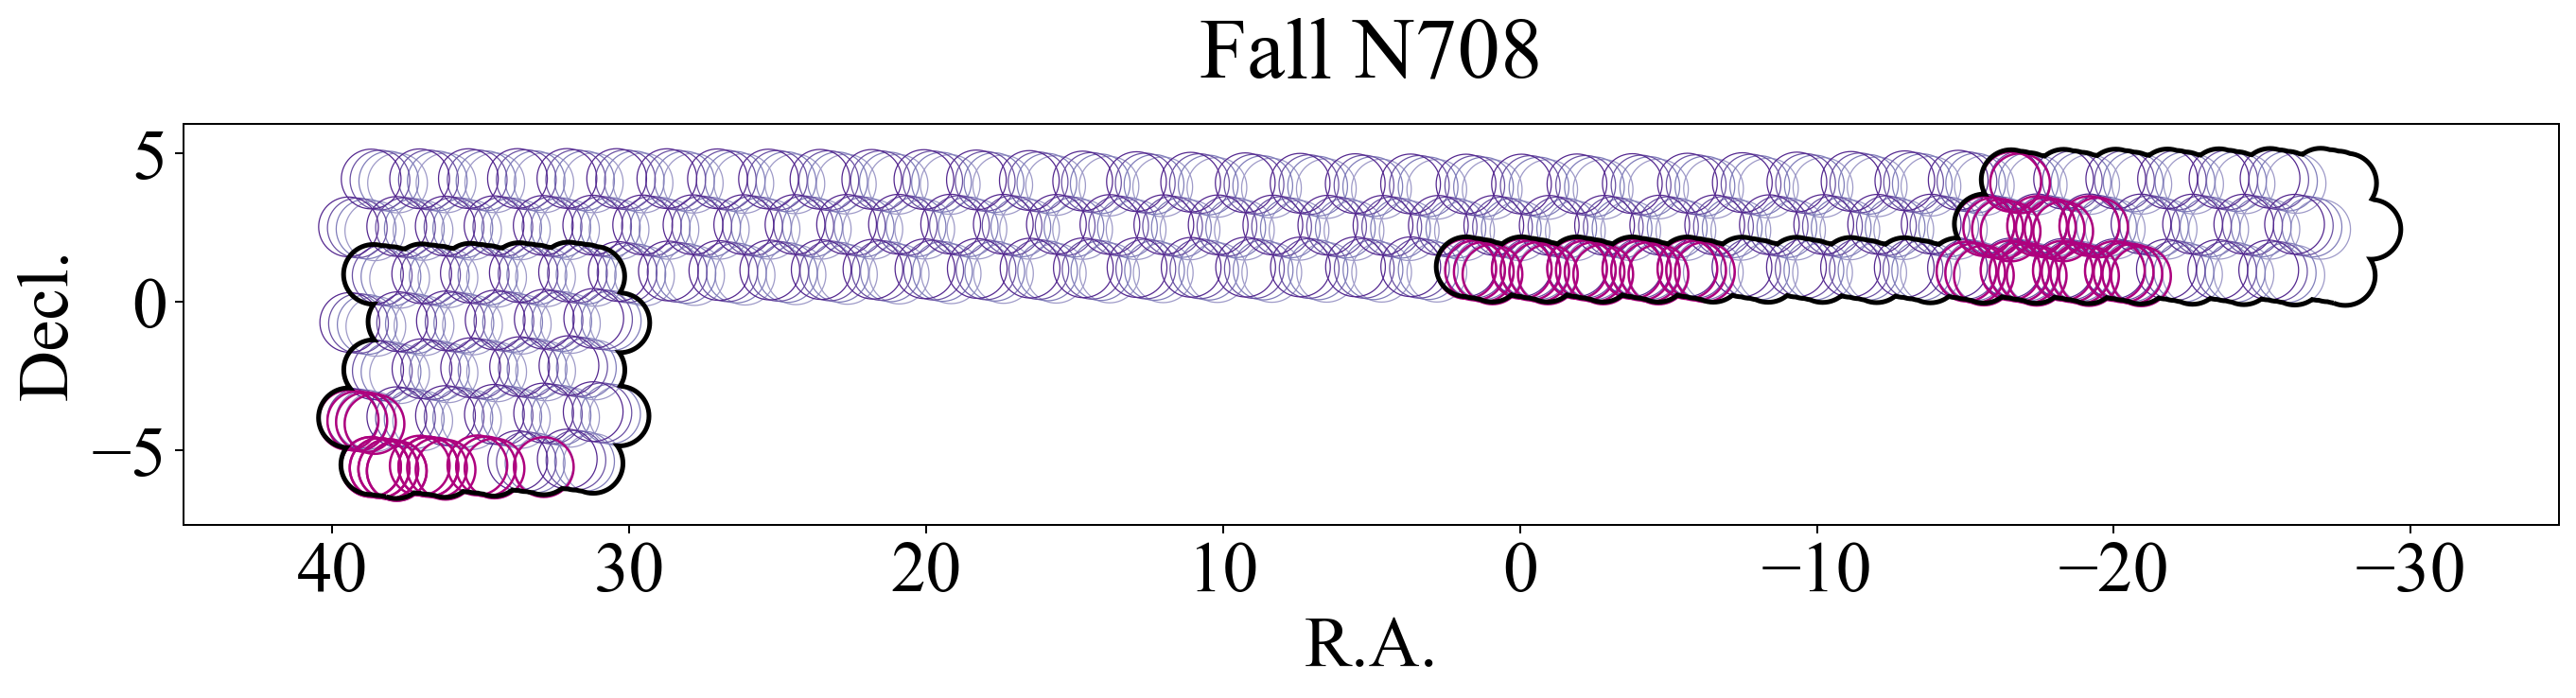

In [135]:
circles_ra_final_pass1 = [Point(fall_ra_final_pass1[i],fall_dec_final_pass1[i]).buffer(circle_radius) for i in range(len(fall_ra_final_pass1))]
circles_ra_final_pass2 = [Point(fall_ra_final_pass2[i],fall_dec_final_pass2[i]).buffer(circle_radius) for i in range(len(fall_ra_final_pass2))]
circles_ra_final_pass3 = [Point(fall_ra_final_pass3[i],fall_dec_final_pass3[i]).buffer(circle_radius) for i in range(len(fall_ra_final_pass3))]
circles_ra_final_pass4 = [Point(fall_ra_final_pass4[i],fall_dec_final_pass4[i]).buffer(circle_radius) for i in range(len(fall_ra_final_pass4))]



fig = plt.figure(1, figsize=(18, 9), dpi=180)
ax = fig.add_subplot(111, aspect='equal')
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 30
plt.rcParams['axes.titlepad'] = 20



for i in range(len(circles_ra_final_pass1)):
    patch1 = PolygonPatch(circles_ra_final_pass1[i],lw=0.5,facecolor='none',edgecolor='#9e9ac8')
    ax.add_patch(patch1)
for i in range(len(circles_ra_final_pass2)):
    patch2 = PolygonPatch(circles_ra_final_pass2[i],lw=0.5,facecolor='none',edgecolor='#807dba')
    ax.add_patch(patch2)
for i in range(len(circles_ra_final_pass3)):
    patch3 = PolygonPatch(circles_ra_final_pass3[i],lw=0.5,facecolor='none',edgecolor='#6a51a3')
    ax.add_patch(patch3)
for i in range(len(circles_ra_final_pass4)):
    patch4 = PolygonPatch(circles_ra_final_pass4[i],lw=0.5,facecolor='none',edgecolor='#54278f')
    ax.add_patch(patch4)
        
    
for i in range(len(circles_observed_fall_n708)):
    patch5 = PolygonPatch(circles_observed_fall_n708[i],lw=1.0,edgecolor='#ae017e',facecolor='none')
    ax.add_patch(patch5)

# the old plan
patch_old_vvds_all = PolygonPatch(old_plan_vvds_union,lw=2,facecolor='none',edgecolor='k', label='old plan')        
ax.add_patch(patch_old_vvds_all)
patch_old_xmm_all = PolygonPatch(old_plan_xmm_union,lw=2,facecolor='none',edgecolor='k')        
ax.add_patch(patch_old_xmm_all)

plt.title('Fall N708')

ax.set_xlim(45,-35)
ax.set_ylim(-7.5,6)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')


Text(0, 0.5, 'Decl.')

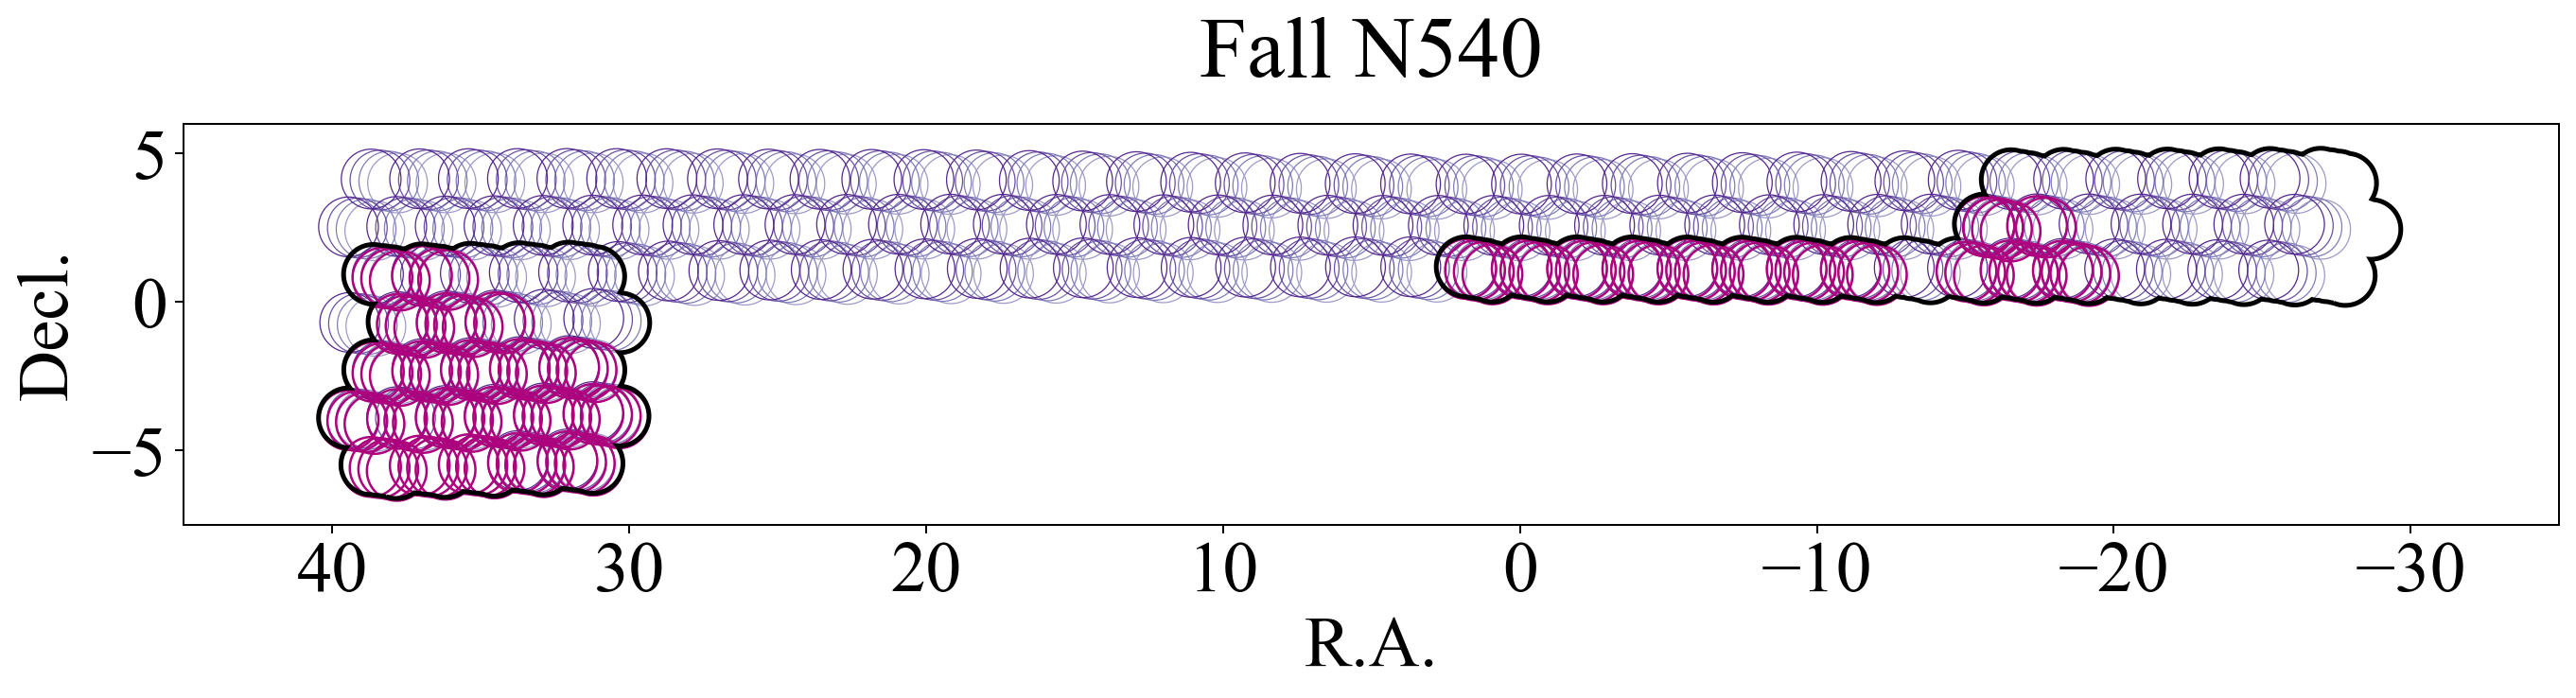

In [136]:
fig = plt.figure(1, figsize=(18, 9), dpi=180)
ax = fig.add_subplot(111, aspect='equal')
for i in range(len(circles_ra_final_pass1)):
    patch1 = PolygonPatch(circles_ra_final_pass1[i],lw=0.5,facecolor='none',edgecolor='#9e9ac8')
    ax.add_patch(patch1)
for i in range(len(circles_ra_final_pass2)):
    patch2 = PolygonPatch(circles_ra_final_pass2[i],lw=0.5,facecolor='none',edgecolor='#807dba')
    ax.add_patch(patch2)
for i in range(len(circles_ra_final_pass3)):
    patch3 = PolygonPatch(circles_ra_final_pass3[i],lw=0.5,facecolor='none',edgecolor='#6a51a3')
    ax.add_patch(patch3)
for i in range(len(circles_ra_final_pass4)):
    patch4 = PolygonPatch(circles_ra_final_pass4[i],lw=0.5,facecolor='none',edgecolor='#54278f')
    ax.add_patch(patch4)

for i in range(len(circles_observed_fall_n540)):
    patch5 = PolygonPatch(circles_observed_fall_n540[i],lw=1.0,edgecolor='#ae017e',facecolor='none')
    ax.add_patch(patch5)

# the old plan
patch_old_vvds_all = PolygonPatch(old_plan_vvds_union,lw=2,facecolor='none',edgecolor='k', label='old plan')        
ax.add_patch(patch_old_vvds_all)
patch_old_xmm_all = PolygonPatch(old_plan_xmm_union,lw=2,facecolor='none',edgecolor='k')        
ax.add_patch(patch_old_xmm_all)

plt.title('Fall N540')

ax.set_xlim(45,-35)
ax.set_ylim(-7.5,6)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')


## save pointings to `.csv` files

In [139]:
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene', propid='2020B-0288', seqid='S2022B')

# xmm_vvds
df_xmm_vvds_N708 = ocat.build_catalog(fall_ra_final, fall_dec_final, 'XMM_VVDS', 'N708', 'object', 10.*60)
df_xmm_vvds_N540 = ocat.build_catalog(fall_ra_final, fall_dec_final, 'XMM_VVDS', 'N540', 'object', 15.*60)

df_xmm_vvds_N708.to_csv('../pointings/xmm_vvds_N708.csv')
df_xmm_vvds_N540.to_csv('../pointings/xmm_vvds_N540.csv')
